In [1]:
#Импортируем имеющиеся модули
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

%matplotlib inline

In [2]:
#Скачиваем дополнительные модули
import urllib.request
import shutil
import os


url = "https://github.com/andrew-veriga/DL/raw/master/assign.zip"
filename = "assign.zip"
urllib.request.urlretrieve(url, filename)

shutil.unpack_archive(filename)
os.remove(filename)

In [3]:
#Импортируем дополнительные модули
from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

In [104]:
def argmax(q_values):
    top_value = float("-inf")
    ties = []

    for i in range(len(q_values)):
        #Если появилось новое максимальное значение, то обнуляем ties и добавляем в него индекс нового макс. значения
        if q_values[i] > top_value:
            ties = [i]
            top_value = q_values[i]
            continue
        #Если элемент является максимальным значением - добавляем его индекс в ties
        if q_values[i] == top_value:
            ties.append(i)
    return np.random.choice(ties)

In [116]:
# -----------
# Тестовая ячейка
# -----------

test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# Установить случайное начальное число, чтобы результаты были детерминированными
np.random.seed(0)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

# убедиться, что argmax не всегда выбирает первое вхождение
assert counts[0] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# убедиться, что argmax не всегда выбирает последнее вхождение
assert counts[3] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# убедиться, что генератор случайных чисел вызван только один раз когда бы  `argmax` ни вызывался
expected = [44, 0, 0, 56] # <-- обратите внимание: не однородный из-за случайности
assert counts == expected

In [149]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):

        #Выбираем действие с максимальной оценкой
        current_action = argmax(self.q_values)

        #Увеличиваем счётчик дёрганий за рычаг для прошлого раза
        self.arm_count[self.last_action] += 1

        self.q_values[self.last_action] += (1/self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])


        self.last_action = current_action

        return current_action


In [152]:
# -----------
# Тестовая ячейка
# -----------

# Построение фейкового агента для проверки и установки некоторых начальных условий
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

# tагент выполняет шаг
action = greedy_agent.agent_step(reward=1, observation=0)

# убедиться, что агент выбирает действие жадно
assert action == 2

# убедиться, что q_values было обновлено корректно
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

100%|██████████| 200/200 [00:04<00:00, 48.68it/s]


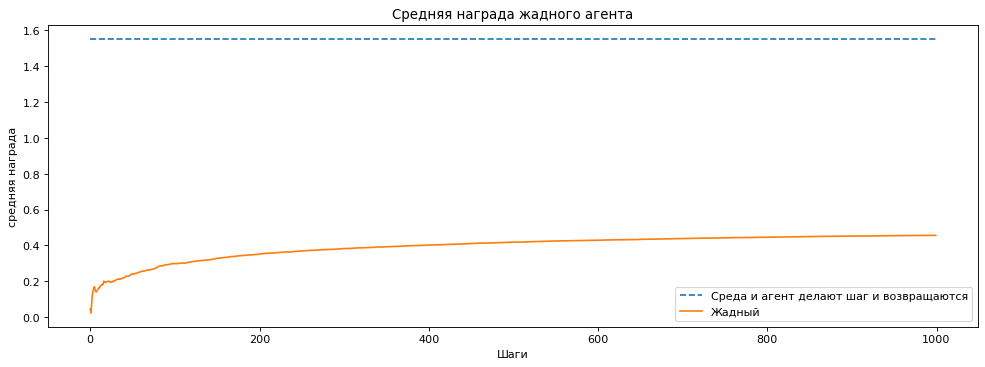

In [153]:
# ---------------
# Дискуссионная ячейка
# ---------------

num_runs = 200                    # количество запусков эксперимента
num_steps = 1000                  # Сколько раз агентом выбрана каждая рука
env = ten_arm_env.Environment     # Устанавливаем, какую среду мы хотим использовать для тестирования
agent = GreedyAgent               # Выбираем, какого агента мы хотим использовать
agent_info = {"num_actions": 10}  # Передаем агенту необходимую информацию. (Здесь - сколько всего рук).
env_info = {}                     # Передаем среде необходимую информацию. (В этом случае - ничего не передаем)

all_averages = []

average_best = 0
for run in tqdm(range(num_runs)):           # tqdm - создает индикатор выполнения
    np.random.seed(run)

    rl_glue = RLGlue(env, agent)          # Создает новый эксперимент RLGlue с окружением и агентом, которые мы выбрали выше.
    rl_glue.rl_init(agent_info, env_info) # передаем RLGlue все, что нужно для инициализации агента и среды.
    rl_glue.rl_start()                    # запускаем эксперимент

    average_best += np.max(rl_glue.environment.arms)

    scores = [0]
    averages = []

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # Среда и агент делают шаг и возвращают
        # награду и выбранное действие.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Среда и агент делают шаг и возвращаются", "Жадный"])
plt.title("Средняя награда жадного агента")
plt.xlabel("Шаги")
plt.ylabel("средняя награда")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

In [ ]:
'''============================================================================================'''

In [211]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):

        #Увеличиваем счётчик дёрганий за рычаг для прошлого раза
        self.arm_count[self.last_action] += 1

        #Обновляем Q
        self.q_values[self.last_action] += (1/self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])


        #Если случайная величина от 0 до 1 < epsilon, то используем epsilon-greedy алгоритм
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        #Иначе используем жадный алгоритм
        else:
            current_action = argmax(self.q_values)

        self.last_action = current_action

        return current_action

In [212]:
# --------------
# Отладочная ячейка
# --------------

# сделать фейкового агента для тестирования и установки некоторых начальных ограничений
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.0, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# учитывая random.seed, мы должны увидеть здесь жадное действие (действие 2)
action = e_greedy_agent.agent_step(reward=1, observation=0)

# -----------------------------------------------
# попробуем угадать несколько более сложных мест
# -----------------------------------------------

# убедиться, что обновляете *last_action*, а не текущее действие
assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

# убедиться, что stepsize основывается на *last_action* а не на текущем действии
assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

# убедитесь, что агент использует argmax, который выбирает максимальные случайным образом
assert action == 2, "C"

# -----------------------------------------------

# посмотрим, что произойдет с другим действием
np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# учитывая этот random.seed, мы должны увидеть здесь случайное действие (действие 4)
action = e_greedy_agent.agent_step(reward=1, observation=0)

# Агент увидел награду 1, поэтому следует увеличить значение для *last_action*
assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

# агент должен был выбрать случайное действие для этого конкретного случайного числа
assert action == 4, "E"

In [214]:
# -----------
# Тестовая ячейка
# -----------

np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# манипулировать random.seed, чтобы агент выполнял случайное действие
np.random.seed(1)
action = e_greedy_agent.agent_step(reward=0, observation=0)

assert action == 4

# убедиться, что ценность действия 4 обновилась
action = e_greedy_agent.agent_step(reward=1, observation=0)
assert e_greedy_agent.q_values == [0, 0.5, 0, 0, 1.0]

100%|██████████| 200/200 [00:03<00:00, 60.95it/s]


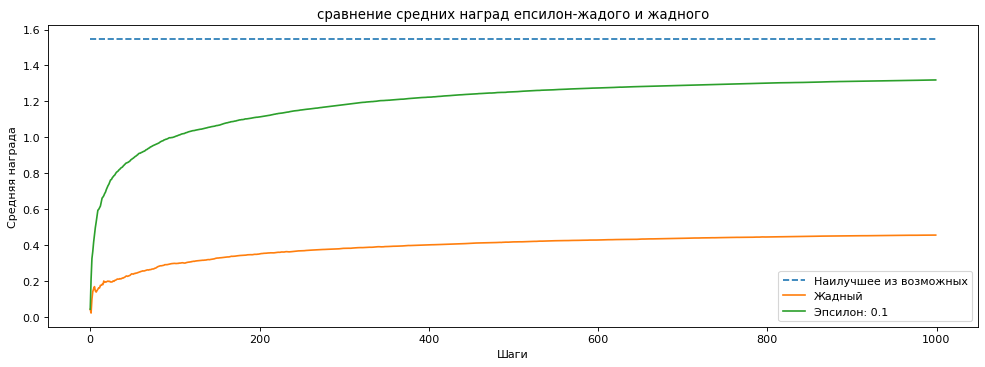

In [217]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Рисует результаты Epsilon-жадных и жадных
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # Среда и агент делают шаг и возвращают
        # награду и выбранное действие.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("сравнение средних наград епсилон-жадого и жадного")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Наилучшее из возможных", "Жадный", "Эпсилон: 0.1"))
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

In [ ]:
'''============================================================================================'''

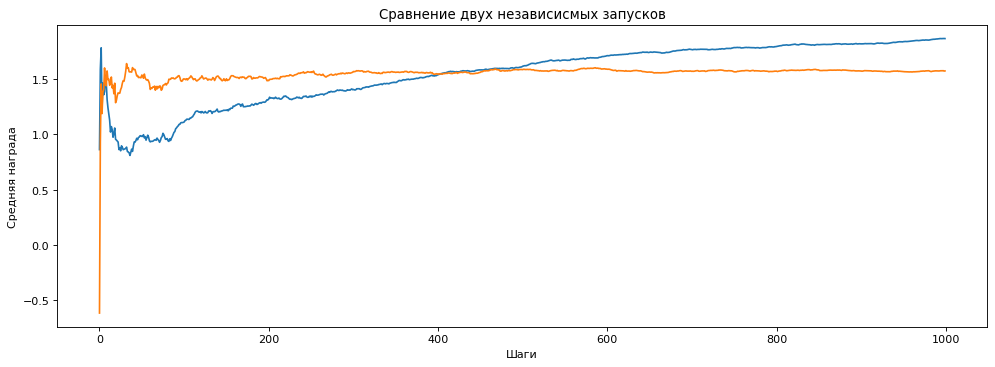

In [219]:
# ---------------
# Дискуссионная ячейка
# ---------------

# график запусков e-greedy агента
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Здесь мы устанавливаем seed, чтобы сравнить два разных запуска
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))

    plt.plot(averages)

plt.title("Сравнение двух независисмых запусков")
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

In [220]:
# ---------------
# Дискуссионная ячейка
# ---------------
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")


print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")

Random Seed 1
Разведка
Разведка
Разведка


Random Seed 2
Разведка


In [ ]:
'''==========================================================================================='''

100%|██████████| 200/200 [00:03<00:00, 62.94it/s]


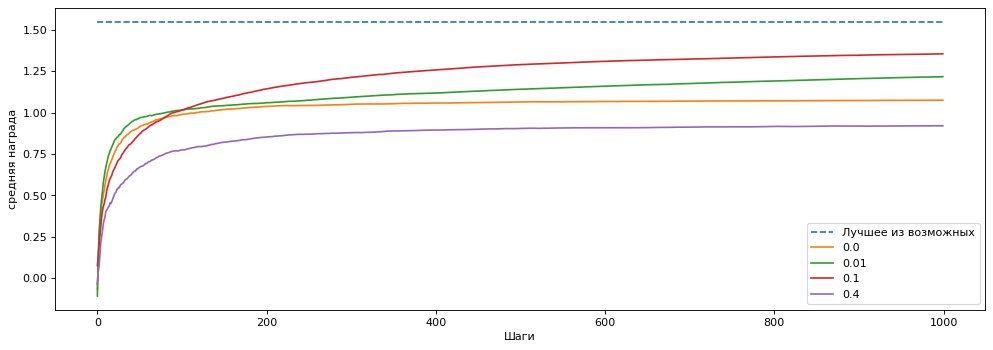

In [221]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Эксперимент для разных e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)

    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Лучшее из возможных"] + epsilons)
plt.xlabel("Шаги")
plt.ylabel("средняя награда")
plt.show()

In [ ]:
'''========================================================================================'''

In [224]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        #Увеличиваем счётчик дёрганий за рычаг для прошлого раза
        self.arm_count[self.last_action] += 1

        #Обновляем Q
        self.q_values[self.last_action] += self.step_size * (reward - self.q_values[self.last_action])


        #Если случайная величина от 0 до 1 < epsilon, то используем epsilon-greedy алгоритм
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        #Иначе используем жадный алгоритм
        else:
            current_action = argmax(self.q_values)

        self.last_action = current_action

        return current_action

In [225]:
# --------------
# Отладочная ячейка
# --------------

for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Убедитесь, что вы правильно обновляете q_values, используя размер шага."

In [226]:
# -----------
# Тестовая ячейка
# -----------

np.random.seed(0)
# Проверить Epsilon Greedy с разными постоянными размерами шага
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size

    action = e_greedy_agent.agent_step(1, 0)

    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]

100%|██████████| 200/200 [00:03<00:00, 51.01it/s]
C:\Users\tolst\AppData\Local\Temp\ipykernel_209712\3670187263.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


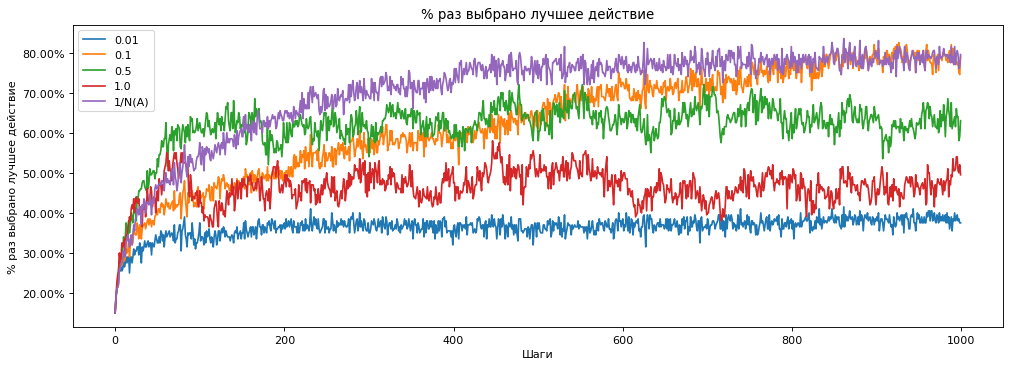

In [227]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Эксперимент для разных размеров шага
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []

        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)

        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% раз выбрано лучшее действие")
plt.xlabel("Шаги")
plt.ylabel("% раз выбрано лучшее действие")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

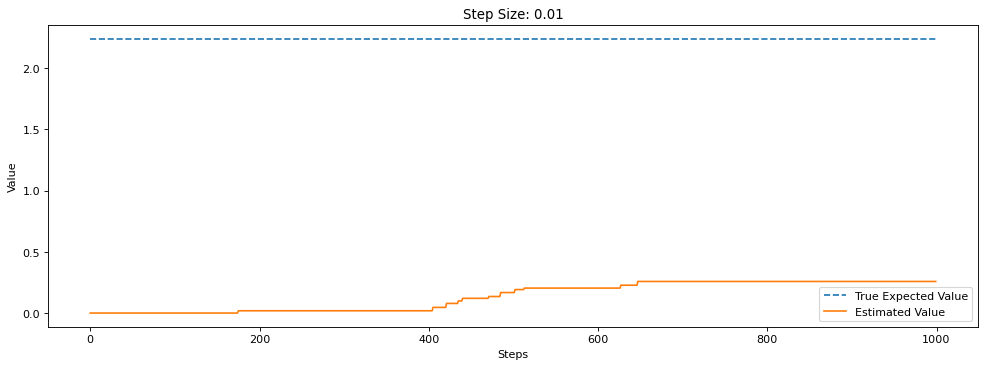

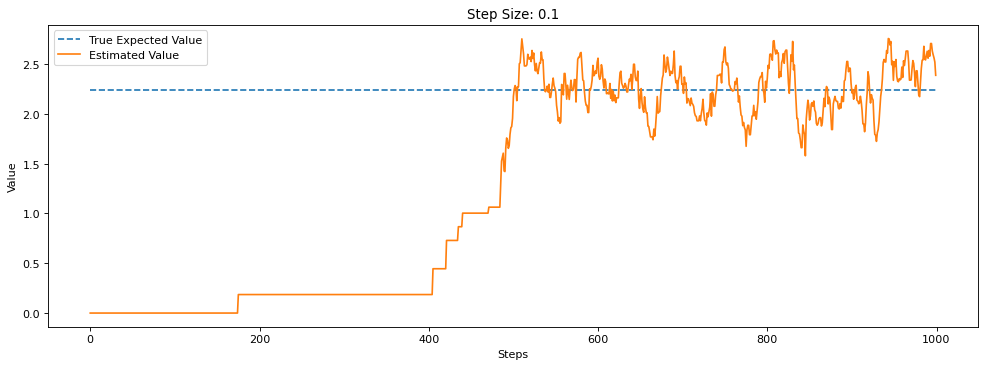

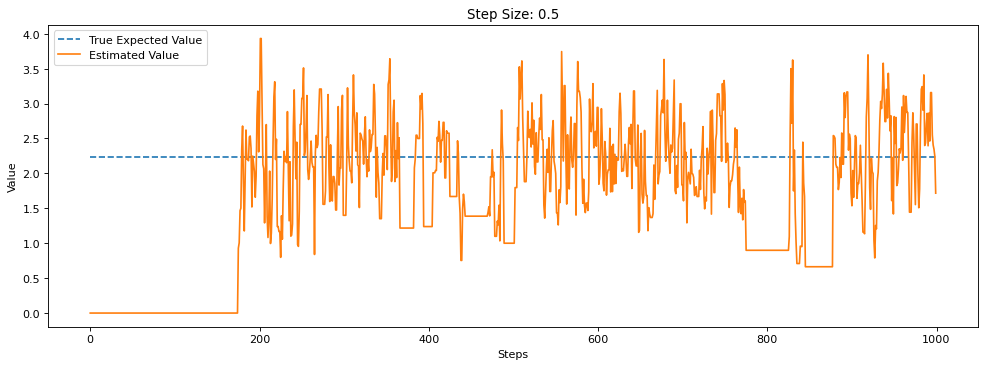

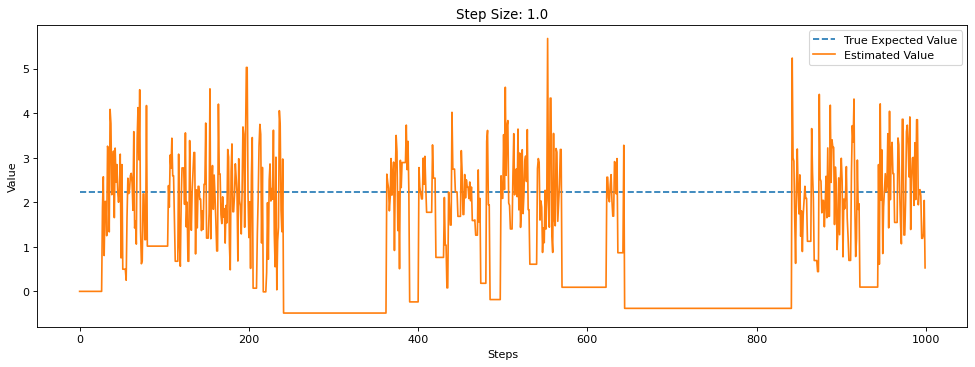

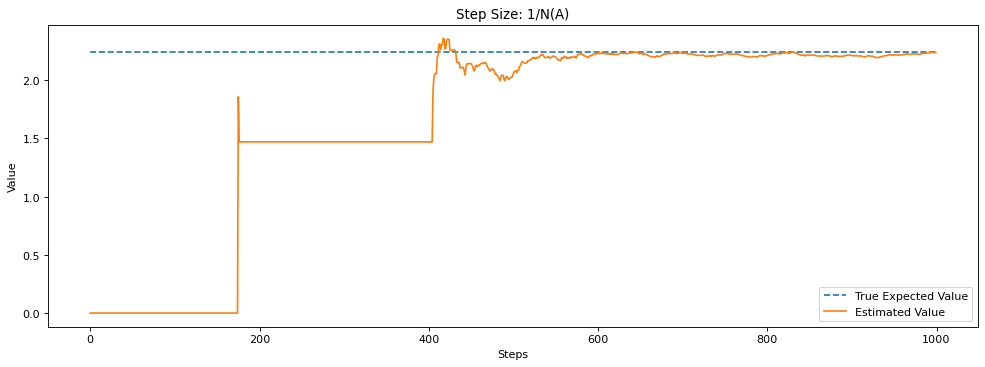

In [228]:
# lock
# ---------------
# Discussion Cell
# ---------------
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

100%|██████████| 200/200 [00:06<00:00, 31.36it/s]


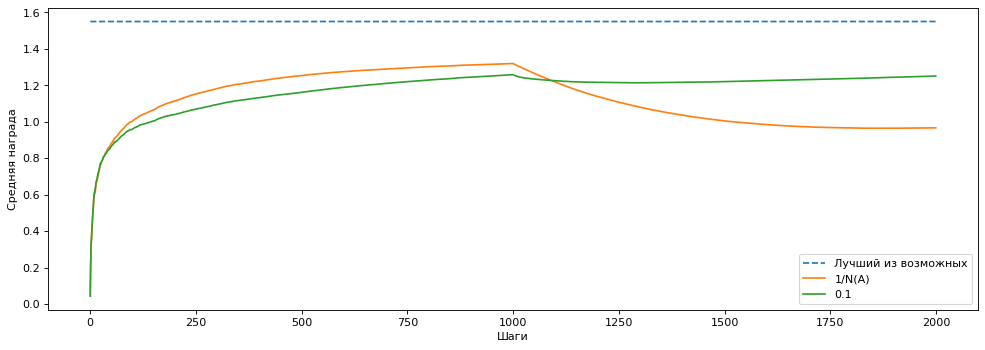

In [229]:
# ---------------
# Дискуссионная ячейка
# ---------------
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)

    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Лучший из возможных", "1/N(A)", "0.1"])
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()